### WPM ratios

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from hol.wpm_ratios import WPMRatios

year1 = 1750
year2 = 1920

years = range(year1, year2)

ratios = WPMRatios(year1, year2)

### Linear regressions

jesus


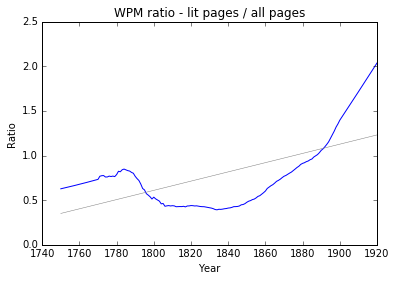

court


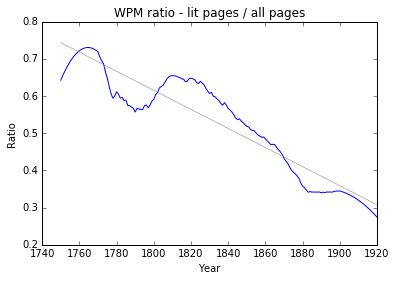

crown


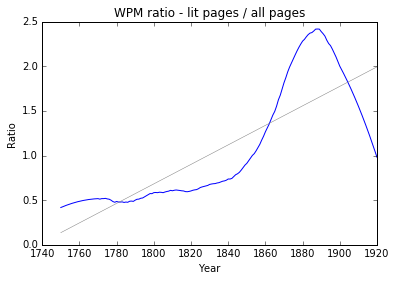

cloth


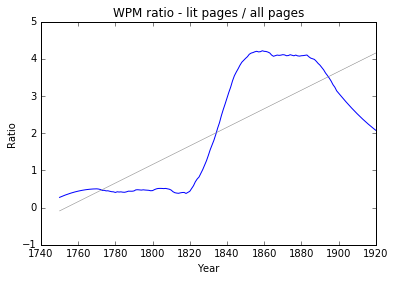

In [25]:
import numpy as np
import statsmodels.api as sm

from hol.utils import lin_reg

def plot_linreg(token):

    series = ratios.smooth_series(token)

    fit = lin_reg(series)

    x1 = list(series.keys())[0]
    x2 = list(series.keys())[-1]

    y1 = fit.predict()[0]
    y2 = fit.predict()[-1]
    
    print(token)

    plt.title('WPM ratio - lit pages / all pages')
    plt.xlabel('Year')
    plt.ylabel('Ratio')
    plt.plot(*zip(*series.items()))
    plt.plot([x1, x2], [y1, y2], color='gray', linewidth=0.5)
    plt.show()

plot_linreg('jesus')
plot_linreg('court')
plot_linreg('crown')
plot_linreg('cloth')

### Token -> slope, p<0.01

In [16]:
import math

def print_ratios(tokens, cols=5):
    
    # Get row count and figure size.
    rows = math.ceil(len(tokens) / cols)
    figsize = (cols*2, rows*2)
    
    # Make the figure + axes.
    fig, axarr = plt.subplots(rows, cols, figsize=figsize)
    fig.tight_layout(pad=0, h_pad=2, w_pad=0.1)
    
    for i, token in enumerate(tokens):
        
        ax = axarr[math.floor(i/cols)][i%cols]
        ax.set_title(token)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
        ax.tick_params(labelsize=8)
        ax.set_xlim(year1, year2)
        
        s = ratios.ratios[token]
        
        ax.plot(
            *zip(*s.items()),
            linestyle='none',
            marker='.',
            markersize=2,
        )

### Decreasing

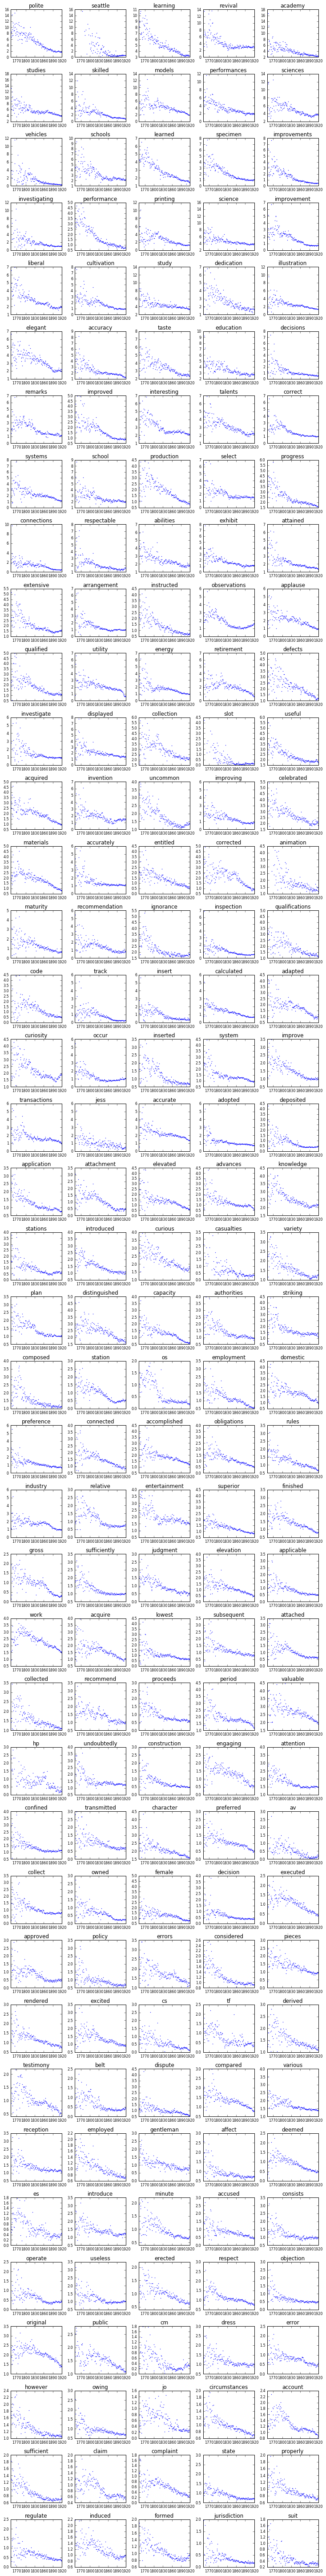

In [4]:
def score(series):
    
    fit = lin_reg(series)
    
    if fit.pvalues[1] < 1e-20:
        return -fit.params[1]
    
result = ratios.query_series(score)

print_ratios(list(result.keys())[:200])

### Increasing

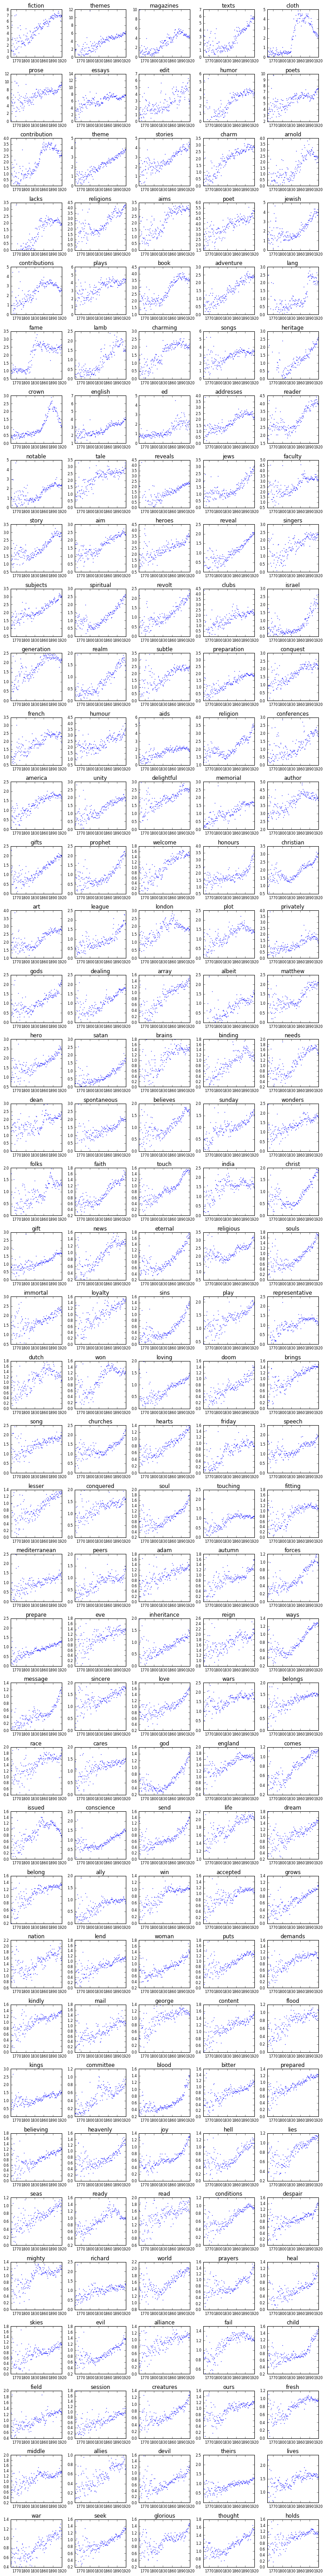

In [5]:
def score(series):
    
    fit = lin_reg(series)
    
    if fit.pvalues[1] < 1e-20:
        return fit.params[1]

result = ratios.query_series(score)

print_ratios(list(result.keys())[:200])

### High median correlation

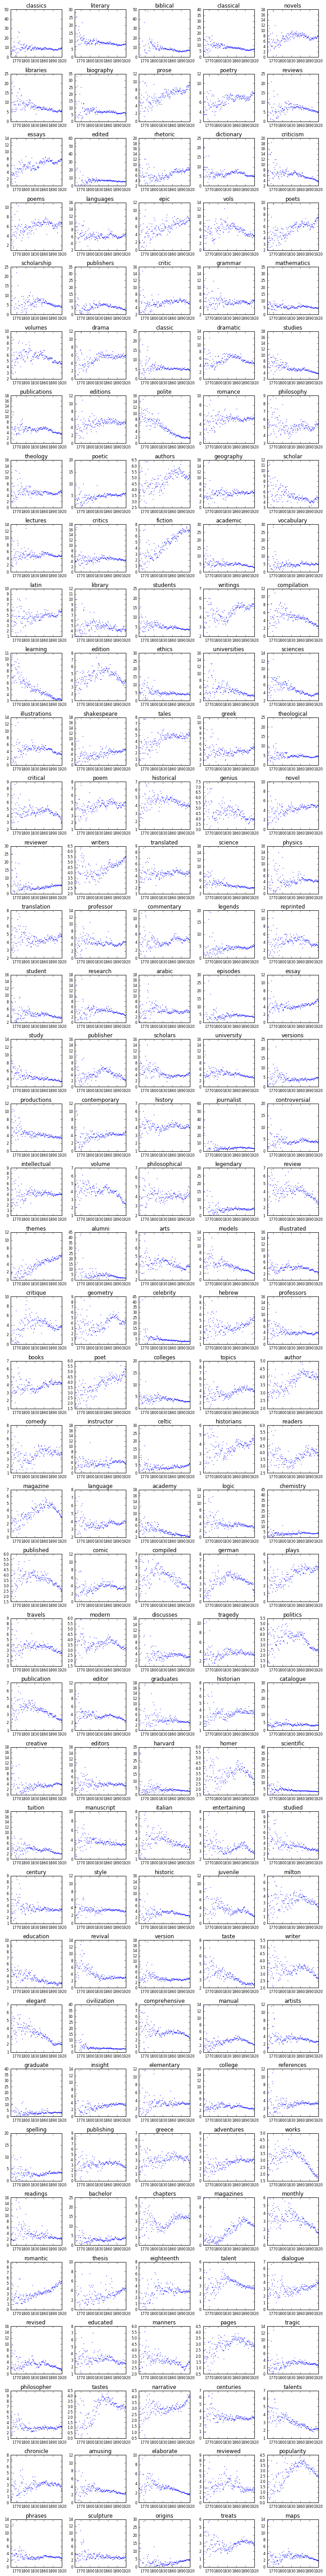

In [17]:
def _high_median(series):

    vals = list(series.values())

    if len(vals) < 150:
        return None

    return np.median(vals)

high_median = ratios.query_series(_high_median)

print_ratios(list(high_median.keys())[:200])

### Weighted KDEs

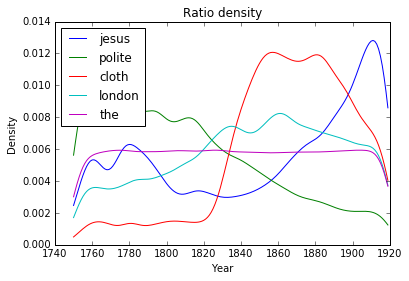

In [14]:
def plot_pdfs(tokens, legend=True):
    for t in tokens:
        
        samples = ratios.pdf(t, years)
        
        plt.title('Ratio density')
        plt.xlabel('Year')
        plt.ylabel('Density')
        plt.plot(*zip(*samples.items()), label=t)
        
        if legend:
            plt.legend(loc='upper left')
        
    plt.show()

plot_pdfs(['jesus', 'polite', 'cloth', 'london', 'the'])

### PDFs for high-correlation words

In [19]:
from collections import OrderedDict

from hol.utils import sort_dict

tokens = list(high_median.keys())[:500]

pdfs = {
    token: ratios.pdf(token, years, bw=20)
    for token in tokens
}

def query_pdfs(_lambda):
    
    result = OrderedDict()
    
    for token, pdf in pdfs.items():
        result[token] = _lambda(pdf)
        
    return sort_dict(result)

1760-1780       1780-1800       1800-1820       1820-1840       1840-1860      1860-1880      1880-1900      1900-1920
--------------  --------------  --------------  --------------  -------------  -------------  -------------  -------------
specimens       specimens       notices         quarterly       cloth          cloth          cloth          texts
princeton       polite          specimens       notices         quarterly      harper         harper         humor
polite          skilled         polite          germany         harper         magazines      magazines      cloth
skilled         investigations  johnson         johnson         magazines      humor          texts          harper
investigations  revival         skilled         attractive      humor          quarterly      humor          magazines
revival         readings        selection       leo             jeremy         texts          themes         theme
learned         selection       printing        publishers     

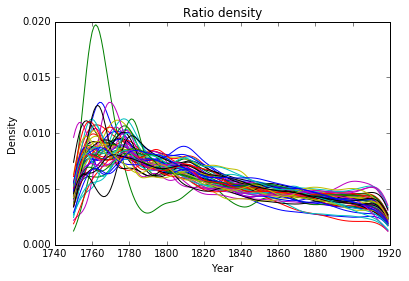

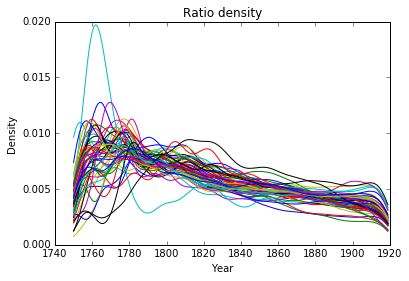

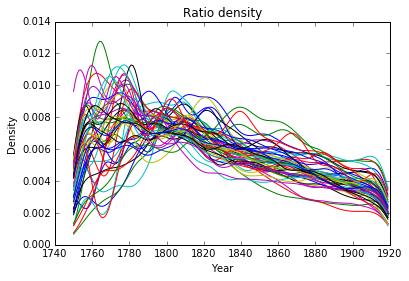

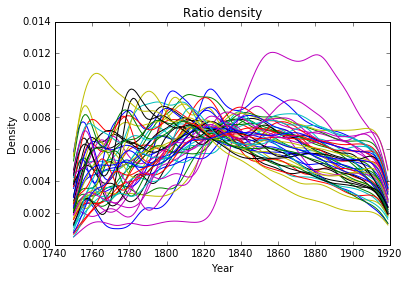

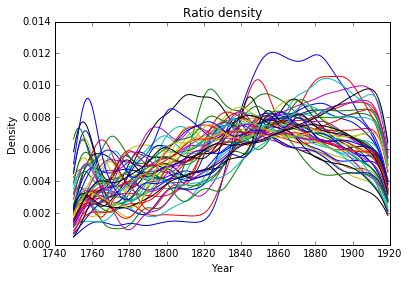

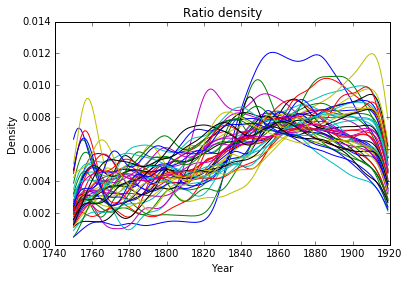

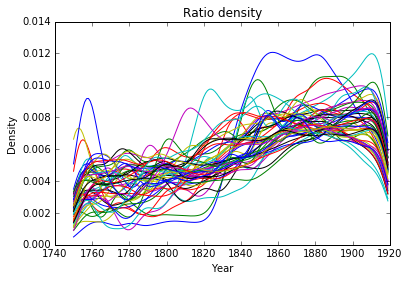

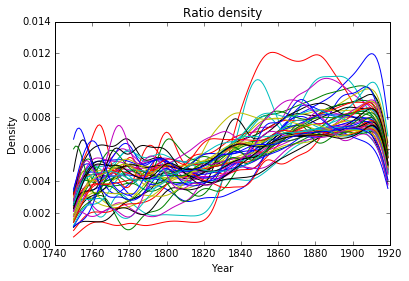

In [20]:
from functools import partial
from tabulate import tabulate

def score(years, pdf):
    return max([pdf.get(y, 0) for y in years])

buckets = [
    (1760, 1780),
    (1780, 1800),
    (1800, 1820),
    (1820, 1840),
    (1840, 1860),
    (1860, 1880),
    (1880, 1900),
    (1900, 1920),
]

cols = [
    query_pdfs(partial(score, range(y1, y2)))
    for y1, y2 in buckets
]

table = []
for i in range(50):
    table.append([list(c.keys())[i] for c in cols])
    
headers = ['{0}-{1}'.format(*b) for b in buckets]
    
print(tabulate(table, headers=headers))

for c in cols:
    plot_pdfs(list(c.keys())[:50], legend=False)

### PDF clustering

In [17]:
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance

def affinity(pdf1, pdf2):
    return distance.braycurtis(pdf1, pdf2)

X = [
    list(pdf.values())
    for token, pdf in pdfs.items()
]

ac = AgglomerativeClustering(affinity=affinity, linkage='average')

ac.fit(X)

TypeError: affinity() missing 1 required positional argument: 'pdf2'